# Pure CNN (with cross-entropy)

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [2]:
gpu_available = tf.test.is_gpu_available()
print(gpu_available)
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
print(is_cuda_gpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


In [3]:
# 清除暫存model
tf.keras.backend.clear_session()

# Hyperparameters

In [4]:
epochs = 20
batch_size = 16
margin = 1.
'''Margin for constrastive loss. (數值通過sigmoid 範圍於0~1)'''

SEED = 2022
#rng  = np.random.default_rng(SEED)
#new_seed = rng.random()
'''fix random seed'''
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Dataset

In [5]:
# Load the MNIST dataset
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

In [6]:
"""
## Define training and validation sets
"""

# Keep 50% of train_val  in validation set
x_train, x_val = x_train_val[:30000], x_train_val[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]
del x_train_val, y_train_val

In [7]:
"""
## Create pairs of images
We will train the model to differentiate between digits of different classes. For
example, digit `0` needs to be differentiated from the rest of the
digits (`1` through `9`), digit `1` - from `0` and `2` through `9`, and so on.
To carry this out, we will select N random images from class A (for example,
for digit `0`) and pair them with N random images from another class B
(for example, for digit `1`). Then, we can repeat this process for all classes
of digits (until digit `9`). Once we have paired digit `0` with other digits,
we can repeat this process for the remaining classes for the rest of the digits
(from `1` until `9`).
"""


def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.
    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.
    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []
    pairs_answers = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]
        pairs_answers += [[label1,label2]]

    return np.array(pairs), np.array(labels).astype("float32"), np.array(pairs_answers) 


# make train pairs
pairs_train, labels_train, pairs_train_answer = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val, pairs_val_answer = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test, pairs_test_answer = make_pairs(x_test, y_test)


In [8]:
"""
We get:
**pairs_train.shape = (60000, 2, 28, 28)**
- We have 60,000 pairs
- Each pair contains 2 images
- Each image has shape `(28, 28)`
"""

"""
Split the training pairs
"""

x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]
"""
Split the validation pairs
"""

x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]
"""
Split the test pairs
"""

x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

In [9]:
"""
## Visualize pairs and their labels
"""


def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.
    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).
    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

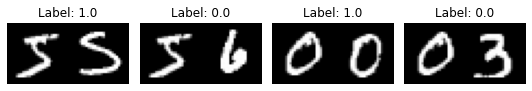

In [10]:
"""
Inspect training pairs
"""

visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

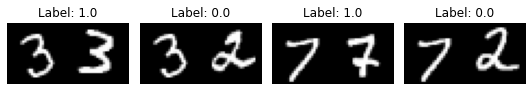

In [11]:
"""
Inspect validation pairs
"""

visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

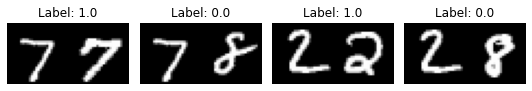

In [12]:
"""
Inspect test pairs
"""

visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

# Model

In [13]:
# Tensorflow tutorial cnn model for mnist
class simple_cnn():
    '''Simple Kuihao's Subclass Style'''
    def __init__(self, input_shape, embedding_dim=2, num_classes=10):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.layers_EmbeddingNet = None
        self.layers_ClassifierNet = None
        
    def define_cnn_embeddings(self):
        EmbeddingNet_input = layers.Input(self.input_shape)
        x = layers.Conv2D(32, (3, 3), activation='relu')(EmbeddingNet_input)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)
        EmbeddingNet_output = layers.Dense(self.embedding_dim, activation=None)(x)
        EmbeddingNet = keras.Model(name='EmbeddingNet_Subclass', inputs=EmbeddingNet_input, outputs=EmbeddingNet_output)
        print(EmbeddingNet.summary())
        self.layers_EmbeddingNet = EmbeddingNet

    def define_classfier(self):
        ClassificationNet_input = layers.Input(self.input_shape)
        embeddnig = self.layers_EmbeddingNet(ClassificationNet_input)
        x = layers.PReLU()(embeddnig)
        ClassificationNet_output = layers.Dense(self.num_classes, activation='softmax')(x)
        ClassificationNet = keras.Model(name='ClassificationNet_Subclass', inputs=ClassificationNet_input, outputs=ClassificationNet_output)
        print(ClassificationNet.summary())
        self.layers_ClassifierNet = ClassificationNet
        
    def forward(self):
        self.define_cnn_embeddings()
        self.define_classfier()
        # compile
        self.layers_ClassifierNet.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
    
    def get_whole_model(self):
        return self.layers_ClassifierNet
    
    def get_EmbeddingNet(self):
        return self.layers_EmbeddingNet

CNN_object = simple_cnn((28,28,1),2,10)
CNN_object.forward()
MyCNN = CNN_object.get_whole_model()

Model: "EmbeddingNet_Subclass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)     

In [14]:
MyCNN.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            batch_size=batch_size,
            epochs=epochs)

Epoch 1/20
1875/1875 [==============================] - 18s 8ms/step - loss: 1.9648 - accuracy: 0.2702 - val_loss: 1.0310 - val_accuracy: 0.6808
Epoch 2/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.7084 - accuracy: 0.8272 - val_loss: 0.6315 - val_accuracy: 0.8571
Epoch 3/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.4033 - accuracy: 0.9234 - val_loss: 0.3956 - val_accuracy: 0.9242
Epoch 4/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2595 - accuracy: 0.9490 - val_loss: 0.2819 - val_accuracy: 0.9510
Epoch 5/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2008 - accuracy: 0.9598 - val_loss: 0.2426 - val_accuracy: 0.9607
Epoch 6/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.1516 - accuracy: 0.9689 - val_loss: 0.2621 - val_accuracy: 0.9622
Epoch 7/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1128 - accuracy: 0.9750 - val_loss: 0.2010 - val_a

In [15]:
results = MyCNN.evaluate(x_test,y_test)
print("test loss, test acc:", results)

313/313 [==============================] - 1s 3ms/step - loss: 0.2189 - accuracy: 0.9785
test loss, test acc: [0.21887578070163727, 0.9785000085830688]


(10000, 2)


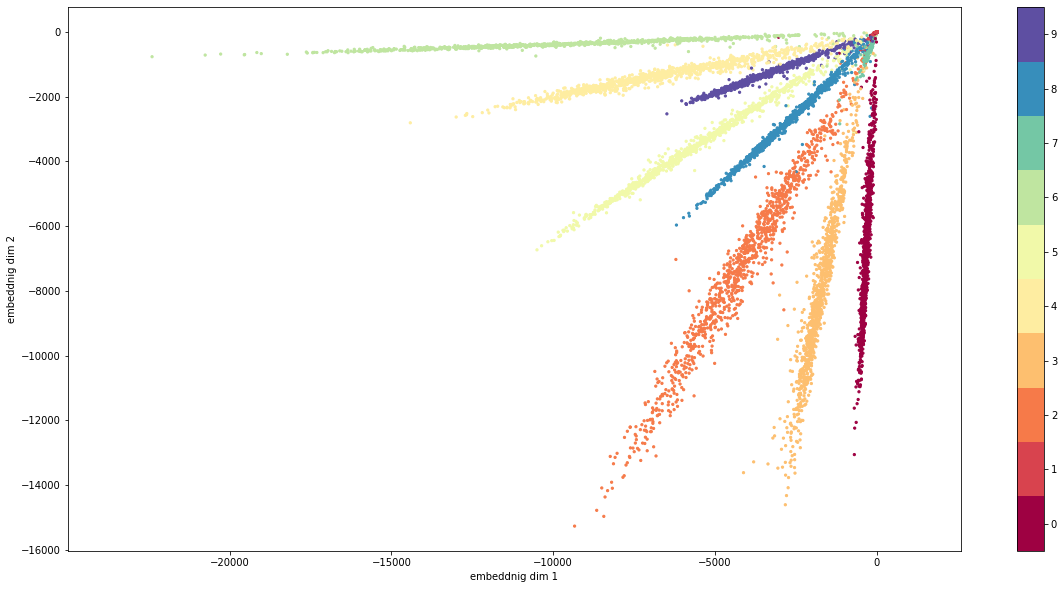

In [16]:
# Testing Set Embeddnig 分布
MyCNN_EmbeddingNet = CNN_object.get_EmbeddingNet()
test_embeddnig = MyCNN_EmbeddingNet.predict(x_test)
print(test_embeddnig.shape)

CNN_fig = plt.figure(figsize=(20,10))
plt.scatter(test_embeddnig[:, 0], test_embeddnig[:, 1], s=5, c=y_test, cmap='Spectral')
CNN_fig.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlabel('embeddnig dim 1')
plt.ylabel('embeddnig dim 2')

plt.show()